In [121]:
# !pip uninstall torch -y
# !pip install torch==2.1.2 torchvision rasterio ollama



In [122]:
from ollama import Client
import random

LLAVA_LLAMA3 = "0ssamaak0/xtuner-llava:llama3-8b-v1.1-f16"
LLAVA_LLAMA3_INT = "0ssamaak0/xtuner-llava:llama3-8b-v1.1-int4"
LLAVA = "llava:34b-v1.6"


class Collama():

    def __init__(self, num_clients, max_retries = 4):
        self.num_clients = num_clients
        self.max_retries = max_retries
        self.clients = [Client(host=f'http://localhost:1200{i}') for i in range(num_clients)]

    def generate(self, *args, **kwargs):
        client = random.choice(self.clients)
        return client.generate(*args, **kwargs)
    
    def chat(self, *args, **kwargs):
        client = random.choice(self.clients)
        return client.chat(*args, **kwargs)

# class Collama():

#     def __init__(self, num_clients, max_retries = 4):
#         self.num_clients = num_clients
#         self.max_retries = max_retries
#         self.clients = [Client(host=f'http://localhost:1200{i}') for i in range(num_clients)]

#     def generate(self, *args, **kwargs):
#         for i in range(self.max_retries):
#             client = random.choice(self.clients)
#             try:
#                 print(args, kwargs)
#                 return client.generate(*args, **kwargs)
#             except Exception as ex:
#                 print(f"Client {client} error: {ex}")
#         # raise ex

#     def chat(self, *args, **kwargs):
#         for i in range(self.max_retries):
#             client = random.choice(self.clients)
#             try:
#                 print(args, kwargs)
#                 return client.chat(*args, **kwargs)
#             except Exception as ex:
#                 print(f"Client {client} error")
#         # raise ex


collama = Collama(1)


# test all clients are running

for c in collama.clients:
    print(c.generate("llama3", "if you can read this reply with 'ok'"))



{'model': 'llama3', 'created_at': '2024-05-04T11:45:14.210912471Z', 'response': 'OK', 'done': True, 'context': [128006, 882, 128007, 198, 198, 333, 499, 649, 1373, 420, 10052, 449, 220, 6, 564, 6, 128009, 128006, 78191, 128007, 198, 198, 4012, 128009], 'total_duration': 4672752612, 'load_duration': 4411775230, 'prompt_eval_count': 21, 'prompt_eval_duration': 118295000, 'eval_count': 2, 'eval_duration': 12097000}


In [123]:
import os


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import rasterio as rio
import glob
import torch
from torch.utils.data import DataLoader, Dataset, random_split
import torch
import torchvision.transforms as transforms
from torchvision import transforms

from rasterio.plot import reshape_as_image
from PIL import Image

# file locations
DATA_PATH = "drive/MyDrive/AIML24"
TRAINING_PATH = DATA_PATH + "/remote_sensing/otherDatasets/sentinel_2/tif"
TEST_PATH = DATA_PATH + "/remote_sensing/otherDatasets/sentinel_2/testset"

# mount g-drive
try:
    from google.colab import drive
    drive.mount('/content/drive')

    # copy files into runtime for performance
    !cp "drive/MyDrive/AIML24" "AIML24"
    DATA_PATH = "AIML24"
except:
    pass # probably local environment



def load_img(img_path:str) -> np.ndarray:
  if img_path.split('.')[-1] == "tif":
    with rio.open(img_path, "r") as d:
      img = d.read([1,2,3,4,5,6,7,8,9,10,11,12,13])
      img = reshape_as_image(img)
  else:
    img = np.load(img_path)
  return img


ids2labels = {
    0: 'AnnualCrop',
    1: 'Forest',
    2: 'HerbaceousVegetation',
    3: 'Highway',
    4: 'Industrial',
    5: 'Pasture',
    6: 'PermanentCrop',
    7: 'Residential',
    8: 'River',
    9: 'SeaLake'
}

labels2ids = {v: k for k, v in ids2labels.items()}

def text2oh(label):
    one_hot = np.zeros(10)
    one_hot.put(labels2ids[label], 1)
    return one_hot

def oh2text(one_hot):
    try:
        one_hot = one_hot["ID"]
    except:
        pass
    try:
        one_hot = one_hot.numpy()
    except:
        pass
    idx = np.argmax(one_hot)
    return ids2labels[idx]

class SentinelTrain(Dataset):
    def __init__(self, transformations=None):
        self.img_paths = [path.replace('\\', '/') for path in glob.glob(os.path.join(TRAINING_PATH, "*", f"*.tif"))]
        self.transformations = transformations

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = load_img(img_path).astype(np.float32)

        if self.transformations:
            image = self.transformations(image)

        label = img_path.split("/")[-1].split("_")[0]
        one_hot = text2oh(label)
        # return image, one_hot
        channels = torch.tensor([c for c in range(12)])
        return image, {"ID": one_hot, "channels": channels}



def get_id(img_path):
    return img_path.split("/")[-1].split("_")[-1].split(".")[0]

class SentinelTest(Dataset):
    def __init__(self, transformations=None):
        self.img_paths = [path.replace("\\","/") for path in glob.glob(os.path.join(TEST_PATH,  f"*.npy"))]
        self.transformations = transformations
    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = load_img(img_path).astype(np.float32)
        image_id = get_id(img_path)

        if self.transformations:
            image = self.transformations(image)
        return image, image_id


# Create instances of the Dataset Class for both train & test


def bandselect(img):
    return img[:, :, [3,2,1]]

def convert_to_float(img):
    return img / 10000.0

def bands_to_front(img):
    return img.permute(2, 0, 1)

# TODO: improvement -> find global max / min
def l2a_approx(img):
    l2a_bands = img[:,:,[0,1,2,3,4,5,6,7,12,8,10,11]]
    return l2a_bands
    # band_min = np.min(l2a_bands, (0,1)) # minimal value per band
    # return l2a_bands - band_min # dark object subtraction algo approximation

train_mean = [1353.7283, 1117.2009, 1041.8888,  946.5547, 1199.1866, 2003.0106,
        2374.0134, 2301.2244, 2599.7827,  732.1823, 1820.6930, 1118.2052]
train_std = [ 65.2964, 153.7740, 187.6989, 278.1234, 227.9242, 355.9332, 455.1324,
        530.7811, 502.1637,  98.9300, 378.1612, 303.1070]
test_mean = [380.1732,  400.1498,  628.8646,  578.8707,  943.4276, 1826.2419,
        2116.6646, 2205.9729, 2281.1836, 2266.9331, 1487.6902,  959.2352]
test_std = [115.1743, 209.1482, 241.2069, 301.1053, 269.5137, 420.2494, 503.8187,
        598.0409, 529.4133, 403.9382, 398.1438, 342.4408]


def normalize_for_display(band_data):
    """Normalize multi-spectral imagery across bands.
    The input is expected to be in HxWxC format, e.g. 64x64x13.
    To account for outliers (e.g. extremly high values due to
    reflective surfaces), we normalize with the 2- and 98-percentiles
    instead of minimum and maximum of each band.
    """
    band_data = np.array(band_data)
    lower_perc = np.percentile(band_data, 2, axis=(0,1))
    upper_perc = np.percentile(band_data, 98, axis=(0,1))

    return (band_data - lower_perc) / (upper_perc - lower_perc)

train_transforms = transforms.Compose([
    l2a_approx,
    # transforms.Normalize(train_mean, train_std),
    transforms.ToTensor(),
    # transforms.GaussianBlur(1),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
])

train_dataset = SentinelTrain(train_transforms)


test_transforms  = transforms.Compose([

    normalize_for_display,
    transforms.ToTensor(),
    # transforms.Normalize(test_mean, test_std),
    # transforms.GaussianBlur(1),
])

test_dataset = SentinelTest(test_transforms)

print(len(train_dataset))
print(len(test_dataset))





# train_dataset_subset, val_dataset_subset = random_split(train_dataset, [.8, .2])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# val_dataloader = DataLoader(val_dataset_subset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Utility function to display image from dataset
from rasterio.plot import reshape_as_image


def print_image(img, label, rgb_bands=[3,2,1])-> None:
  """Displays an image. Indices of bands given by "rgb_bands" will be displayed as RGB in the print
  """
  img = img.numpy()
  img = img.transpose(1,2,0)
#   img = normalize_for_display(img)
  img = img[:, :, rgb_bands]
  fig, ax = plt.subplots(1, figsize=(5,5))
  ax.imshow((img * 255).astype(np.uint8), vmin=0, vmax=255)

  label = oh2text(label["ID"])
  ax.set_title(label)
  ax.axis(False)
  plt.tight_layout()

  plt.show()

27000
4232


<Axes: ylabel='Count'>

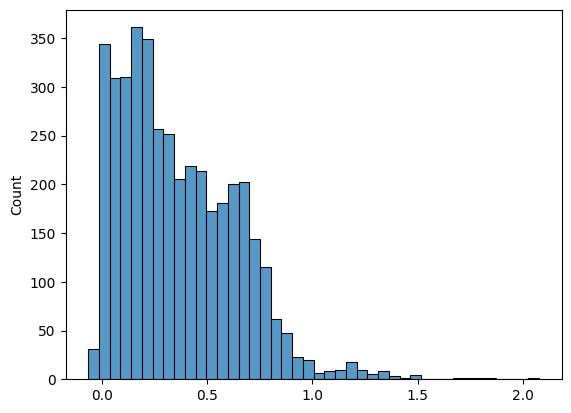

In [124]:
import seaborn as sns
sns.histplot(test_dataset.__getitem__(30)[0][2].flatten())

In [125]:


def img2b64(img):
    rgb_bands = [3,2,1]



    img = img.numpy()
    img = img.transpose(1,2,0)
    img = normalize_for_display(img)
    img = img[:, :, rgb_bands]
    # fig, ax = plt.subplots(1, figsize=(5,5))
    # img = plt.imshow((img * 255).astype(np.uint8), vmin=0, vmax=255)
    img = plt.imshow(img, vmin=0, vmax=255)



    plt.axis('off')
    plt.tight_layout()
    # plt.savefig("test.png", bbox_inches='tight')

    import io
    import base64
    my_stringIObytes = io.BytesIO()
    plt.savefig(my_stringIObytes, format='jpg')
    my_stringIObytes.seek(0)
    my_base64_jpgData = base64.b64encode(my_stringIObytes.read()).decode()
    return my_base64_jpgData



<Axes: ylabel='Count'>

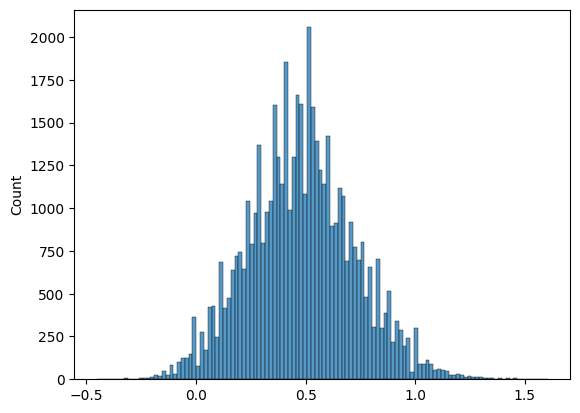

In [126]:
import seaborn as sns

sns.histplot(test_dataset.__getitem__(4200)[0].flatten())

Few shot binary classification

1. focus on single label at a time
2. Show examples of 1.0

In [127]:
# import ollama

# ollama.pull('llama3')
# ollama.pull('llama3:70b')

# ollama.pull('llava')
# ollama.pull('llava:34b')
# ollama.pull('llava:13b')



In [128]:

# from collections import defaultdict
# img, label = test_dataset.__getitem__(2000)
# imgb64 = img2b64(img)

# init_prompt = """
# The following image is a sattelite image from the Sentinel 2 sattelite. The task is to classify the land use into predefined categories

# Available classes are:
# AnnualCrop
# Forest
# HerbaceousVegetation
# Highway
# Industrial
# Pasture
# PermanentCrop
# Residential
# River
# SeaLake

# The following are example images and classes.
# """
# # ollama.chat(model="llava", prompt=prompt, images=[imgb64])['response']

# initial_message = {
# 			'role': 'user',
# 			'content': init_prompt,
# 			'images': []
# 		}

# q = f"""From the list of land use categories provided earlier, what description fits this image best? Anser by providing the class label exactly as stated. 

# Available classes are:
# AnnualCrop
# Forest
# HerbaceousVegetation
# Highway
# Industrial
# Pasture
# PermanentCrop
# Residential
# River
# SeaLake

# If unsure which label to predict, choose the one that has the highest likelihood.
# """

# examples = [5, 700, 2000, 2400, 3500, 4500, 6000, 7000, 8000, 9000, 10000, 11000, 13000, 14000, 16000, 17000, 19000, 20000, 22000, 23000, 25000, 26000]


# images = defaultdict(list)
# for example in examples:
#     img, label = train_dataset.__getitem__(example)
#     imgb64 = img2b64(img)
#     label = oh2text(label["ID"])
#     images[label].append(imgb64)

# classes = list(images.keys())

# negative_examples = {
#     "AnnualCrop": [images["Pasture"][0], images["PermanentCrop"][0]],
#     "Forest": [images["Industrial"][0], images["SeaLake"][0]],
#     "HerbaceousVegetation": [images["AnnualCrop"][0], images["PermanentCrop"][0]],
#     "Highway": [images["Pasture"][0], images["River"][0]],
#     "Industrial": [images["Forest"][0], images["Residential"][0]],
#     "Pasture": [images["AnnualCrop"][0], images["PermanentCrop"][0]],
#     "PermanentCrop": [images["Pasture"][0], images["AnnualCrop"][0]],
#     "Residential": [images["Industrial"][0], images["Forest"][0]],
#     "River": [images["Highway"][0], images["Pasture"][0]],
#     "SeaLake": [images["Forest"][0], images["Industrial"][0]]
# }

# # example_messages = []

# # for l, i in images:
# #     q_message = {
# # 			'role': 'user',
# # 			'content': q,
# # 			'images': [i]
# # 		}
# #     a_message = {
# # 			'role': 'assistant',
# # 			'content': f"{l}",
# # 			'images': [i]
# # 		}
# #     example_messages.append(q_message)
# #     example_messages.append(a_message)

In [129]:
# # embellish prompt
# import ollama
# l = "River"

# embellish_q = f"Describe in a few sentences what you would expect a sattelite image displaying {l} to look like. Describe the main Features and how such images could be differentiated from other types of land use."

# r = ollama.generate(model="llama3", prompt=embellish_q)
# embellish_a = r["response"]


# binary_prompt = f"""
#     You are an expert in detecting {l} in low quality sattelite images. {embellish_a}
#     Does the image show {l}?
#     Verify the correctness of the Answer.
#     Answer by giving a likelihood ranging from 0.0 to 1.0, do not provide any other sentences.
# """

# img, label = train_dataset.__getitem__(3000)
# imgb64 = img2b64(img)
# r = ollama.generate(model="llava", prompt=binary_prompt, images=[imgb64])
# r["response"]

In [130]:
# c = "SeaLake"
# r = ollama.generate(model="llama3", prompt=f"Rewrite the following word into a plural form to use it in a sentence. If necessary, split the word into multiple words, without loosing any of its meaning. Multiple words can be separated by the word and. The word is {c} Answer by providing the plural versions of the word only, without writing any other text.")

In [131]:
# class_plurals = {
#     'Pasture': "pastures",
#     'River': "rivers",
#     'SeaLake': "the sea or lakes",
#     'PermanentCrop': "permanent crops",
#     'Industrial': "industrial areas",
#     'HerbaceousVegetation': "herbaceous vegetation",
#     'Forest': "forests",
#     'Residential':"residential areas",
#     'AnnualCrop': "annual crops",
#     'Highway': "highways"
# }

# def embellish_description(l):    
#     embellish_q = f"Describe in a few sentences what you would expect a low quality sattelite image from the Eurosat Dataset displaying {class_plurals[l]} to look like. \
#         Describe the main features, the expected colors and how such images could be differentiated from other types of land use."

#     r = ollama.generate(model="llama3", prompt=embellish_q)
#     embellish_a = r["response"]
#     return embellish_a


# # class_prompts = {c:  for c in classes}



# class_history = defaultdict(list)
# for c in classes:

#     class_history[c].append({
# 			'role': 'user',
# 			'content': f"""
# You are an expert in detecting {class_plurals[c]} in low quality sattelite images. {embellish_description(c)}
# f"What is the likelihood that  the image shows {class_plurals[c]}? Answer by giving a number from 0.0 to 1.0, with 0.0 indicating no presence of {class_plurals[c]} and 1.0 indicating a absolute certainty that it shows {class_plurals[c]}.

# Answer by giving a likelyhood ranging from 0.0 to 1.0, with 0.0 indicating no presence of {class_plurals[c]} and 1.0 indicating a absolute certainty that it shows {class_plurals[c]}.\
# If you are unsure, use a value of 0.0.
# Do not provide any other information apart from the score.
# """,
# 			'images': images[c]
# 		})
#     class_history[c].append({
# 			'role': 'assistant',
# 			'content': "1.0",
# 		})
#     class_history[c].append({
# 			'role': 'user',
# 			'content': f"What is the likelihood that  the image shows {class_plurals[c]}? Answer by giving a number from 0.0 to 1.0, with 0.0 indicating no presence of {class_plurals[c]} and 1.0 indicating a absolute certainty that it shows {class_plurals[c]}. Return the number only.",
# 			'images': negative_examples[c]
# 		})
#     class_history[c].append({
# 			'role': 'assistant',
# 			'content': "0.0",
# 		})



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

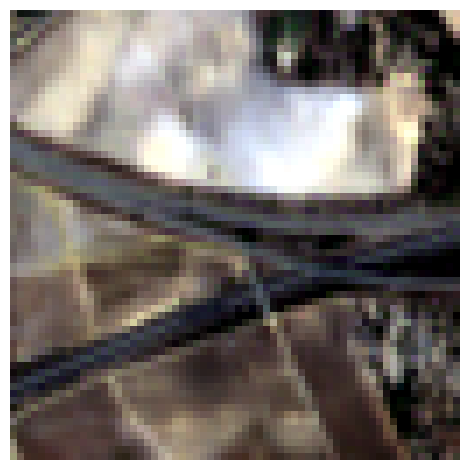

In [132]:
class_examples = {
    'AnnualCrop': [100, 116],
    'Pasture': [1035, 1037],
    'River': [136, 1017],
    'SeaLake': [2204, 137],
    'PermanentCrop': [51, 1030],
    'Industrial': [1008, 1022],
    'HerbaceousVegetation': [1016],
    'Forest': [163,175],
    'Residential': [99, 1006],
    'Highway': [112, 1024]
}

def load_b64(id):
    img = test_dataset.__getitem__(id)[0]
    return img2b64(img)

class_examples = {c: [load_b64(img) for img in imgs] for c, imgs in class_examples.items()}
negative_examples = {
    "AnnualCrop": [class_examples["Pasture"][0], class_examples["PermanentCrop"][0]],
    "Forest": [class_examples["Industrial"][0], class_examples["SeaLake"][0]],
    "HerbaceousVegetation": [class_examples["AnnualCrop"][0], class_examples["PermanentCrop"][0]],
    "Highway": [class_examples["Pasture"][0], class_examples["River"][0]],
    "Industrial": [class_examples["Forest"][0], class_examples["Residential"][0]],
    "Pasture": [class_examples["AnnualCrop"][0], class_examples["PermanentCrop"][0]],
    "PermanentCrop": [class_examples["Pasture"][0], class_examples["AnnualCrop"][0]],
    "Residential": [class_examples["Industrial"][0], class_examples["Forest"][0]],
    "River": [class_examples["Highway"][0], class_examples["Pasture"][0]],
    "SeaLake": [class_examples["Forest"][0], class_examples["Industrial"][0]]
}




In [133]:


class_plurals = {
    'Pasture': "pastures",
    'River': "rivers",
    'SeaLake': "the sea or lakes",
    'PermanentCrop': "permanent crops",
    'Industrial': "industrial areas",
    'HerbaceousVegetation': "herbaceous vegetation",
    'Forest': "forests",
    'Residential':"residential areas",
    'AnnualCrop': "annual crops",
    'Highway': "highways"
}

def embellish_description(l):    
    embellish_q = f"Describe in a few sentences what you would expect a low quality sattelite image from the Eurosat Dataset displaying {class_plurals[l]} to look like. \
        Describe the main features, the expected colors and how such images could be differentiated from other types of land use."

    r = collama.generate(model="llama3", prompt=embellish_q)
    embellish_a = r["response"]
    return embellish_a

def prime_prompt(c):
    return f"You are an expert in detecting {class_plurals[c]} in low quality sattelite images. {embellish_description(c)} \n \
    These images provided are examples of images showing {class_plurals[c]}. Probability: 1.0"

def prime_negative_prompt(c):
    return f"These images are not likely to feature any {class_plurals[c]}. Probability: 0.0"   

def binary_prompt(c):
    # return f"Does the image show {class_plurals[c]}? \n \
    # Take into account the images provided as examples earlier. \n \
    # Carefully consider the features that indicate the presence of {class_plurals[c]} as well as the features pointing towards a different type of land use. and assign a probabilitly of it containing {class_plurals[c]}. \n \
    # Answer by giving only a value on a scale from 0.0 (meaning there is little evidence for it to contain \
    # {class_plurals[c]}) to 1.0 (contains primarily {class_plurals[c]} with high certainty). \
    # Return only the probability value and no additional information.\
    # \n Probability:"
    return f"How probable do you think is it, that the image provided shows {class_plurals[c]}? Probability:"



In [134]:
import sys
import time
import traceback
from joblib.externals.loky import set_loky_pickler
from joblib import parallel_config
from joblib import Parallel, delayed
from joblib import wrap_non_picklable_objects
import ollama

class Conversation():

    def __init__(self, model, context=None):
        self.model = model
        self.context = context
    
    def __reduce__(self):
        return (self.__class__,  (self.model, self.context) )

    def reply(self, prompt, images=[], save_ctx=True):
        # print(f"{prompt} \n images {len(images)}")
        res = ollama.generate(model=self.model, prompt=prompt, images=images, context=self.context, options={"num_ctx": 4096, "temperature":.5})
        if save_ctx:
            self.context = res["context"]
        print(f"{res['total_duration'] / 1e9} seconds")
        return res["response"]
    

class BinaryClassifier():

    def __init__(self, cls, model):
        self.cls = cls
        self.conv = Conversation(model)

    def __reduce__(self):
        return (self.__class__, (self.cls, self.conv))

    def prime(self, examples, negative_examples):
        prompt = prime_prompt(self.cls)
        self.conv.reply(prompt=prompt, images=examples)

        #negative examples
        prompt = prime_negative_prompt(self.cls)
        self.conv.reply(prompt=prompt, images=negative_examples)

    def predict(self, img):
        imgb64 = img2b64(img)
        # print(binary_prompt(self.cls))
        return (self.cls, self.conv.reply(prompt=binary_prompt(self.cls), images=[imgb64], save_ctx=False))
    
class ExpertGroup():

    def __init__(self, model, classes):
        self.model= model
        self.experts = {c: BinaryClassifier(c, model) for c in classes}

    def prime(self, examples):
        tasks = [delayed(self.experts[c].prime)(imgs) for c, imgs in examples.items()]
        Parallel(n_jobs=collama.num_clients, backend="threading")(tasks)

    def predict(self, img):
        tasks = [delayed(expert.predict)(img) for _, expert in self.experts.items()]
        results = Parallel(n_jobs=collama.num_clients, backend="threading")(tasks)
        return {t[0]: t[1] for t in results}


In [135]:
forest_expert = BinaryClassifier("Forest", LLAVA)
forest_expert.prime(class_examples["Forest"], negative_examples["Forest"])

22.338876182 seconds
11.458730991 seconds


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8.978723751 seconds


('Forest',
 "The image you've provided is highly distorted and corrupted, making it impossible to accurately interpret any part of the image. The distortion includes pixelation, color bleeding, and visual artifacts that make it difficult to discern any features or patterns that might be indicative of forested areas.\n\nGiven the current state of this image, it is not suitable for identifying forests or any other land use patterns. The probability of it showing a forest would be 0 due to the lack of coherent information in the image.")

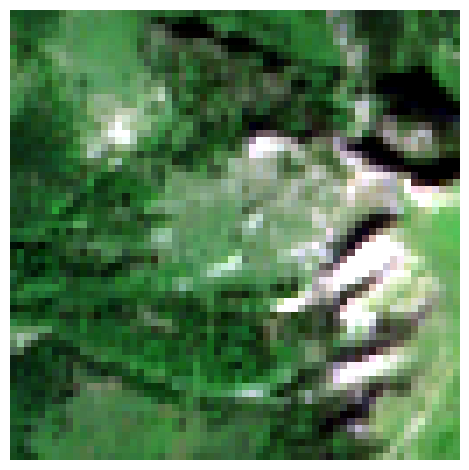

In [136]:
img, ids= test_dataset.__getitem__(180)

pred = forest_expert.predict(img)
pred

In [142]:
img = class_examples["Forest"][0]
ollama.generate(model=LLAVA, prompt="""
describe this aerial image. Pretend that the image quality is superb and all features are clearly visible.
""", images=[img])["response"]

'The image provided is extremely blurry and low-resolution, making it challenging to discern any specific details or features. If the image quality were superb with all features clearly visible, I would be able to provide a detailed description of the aerial view, such as landscape features like roads, bodies of water, buildings, vegetation, or other points of interest. However, due to the current state of the image, it is not possible to describe its content accurately.'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


'0.9'

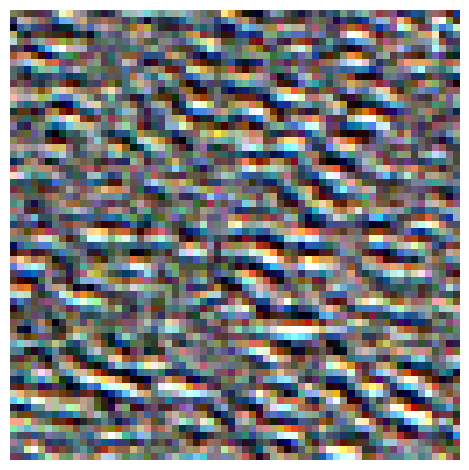

In [137]:
img = img2b64(test_dataset.__getitem__(2)[0])

res = ollama.generate(model=LLAVA, prompt="""
could this low resolution aerial image show forests? 
Ignore the low resolution and potential color shift.
Return the probability on a scale from 0.0 to 1.0.
Return only the number.
""", images=[img])

res["response"]

In [138]:
def take_best_class(res):
    best_value = .0
    best_class = None

    for c, val in res.items():
        if val > best_value:
            best_value = val
            best_class = c
    
    

model = LLAVA_LLAMA3
expert_group = ExpertGroup(model, class_examples.keys())
tasks = expert_group.prime(class_examples)




TypeError: BinaryClassifier.prime() missing 1 required positional argument: 'negative_examples'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.795393935 seconds


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.682628078 seconds


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.692225541 seconds


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.611901626 seconds


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.714203858 seconds


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.729927433 seconds


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.66935847 seconds


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.673279394 seconds


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.752213028 seconds


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.71500632 seconds


{'AnnualCrop': '0.0',
 'Pasture': '0.5',
 'River': '0.0',
 'SeaLake': '0.0',
 'PermanentCrop': '0.0',
 'Industrial': '0.0',
 'HerbaceousVegetation': '0.0',
 'Forest': '0.0',
 'Residential': '0.5',
 'Highway': '0.0'}

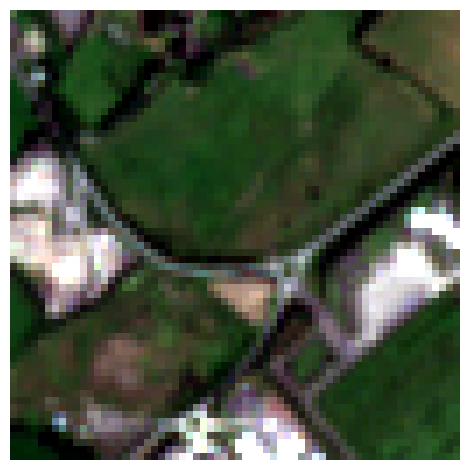

In [ ]:
def take_best_class(res):
    best_value = .0
    best_class = None

    for c, val in res.items():
        try:
            val = float(val)
        except:
            print(f"For {c}, no value was found: {val}")
            continue
        if val > best_value:
            best_value = val
            best_class = c
            img, ids= test_dataset.__getitem__(1000)

    return best_value, best_class

img, ids= test_dataset.__getitem__(1000)

preds = expert_group.predict(img)

_ = img2b64(img)

# take_best_class(preds)
preds

In [ ]:
preds

{'AnnualCrop': '0.5',
 'Pasture': '0.5',
 'River': '0.5',
 'SeaLake': '0.5',
 'PermanentCrop': '0.5',
 'Industrial': '0.5',
 'HerbaceousVegetation': '0.5',
 'Forest': '0.5',
 'Residential': '0.5',
 'Highway': '0.0'}

In [ ]:
_ = img2b64(img)

In [ ]:
classArray = []

for i in range(len(test_dataset.img_paths)[:5]):
    img, img_id = test_dataset.__getitem__(i)
    preds = expert_group.predict(img)
    pred = take_best_class(preds)

    print(pred)
    # img_ids = [get_id(path) for path in paths]
    # preds = model(imgs.to("cuda"))
    # preds = list(preds.logits.detach())
    # preds = [oh2text(pred.detach().cpu()) for pred in preds]
    classArray.append((img_id, pred))

import csv
from datetime import datetime

execution_start = datetime.now().strftime("%m%d%Y-%H%M%S")
with open(f'{execution_start}.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['test_id', 'label'])

    # Write each string to a row with its corresponding index as the test_id
    for i, label in classArray:
        writer.writerow([i, label])